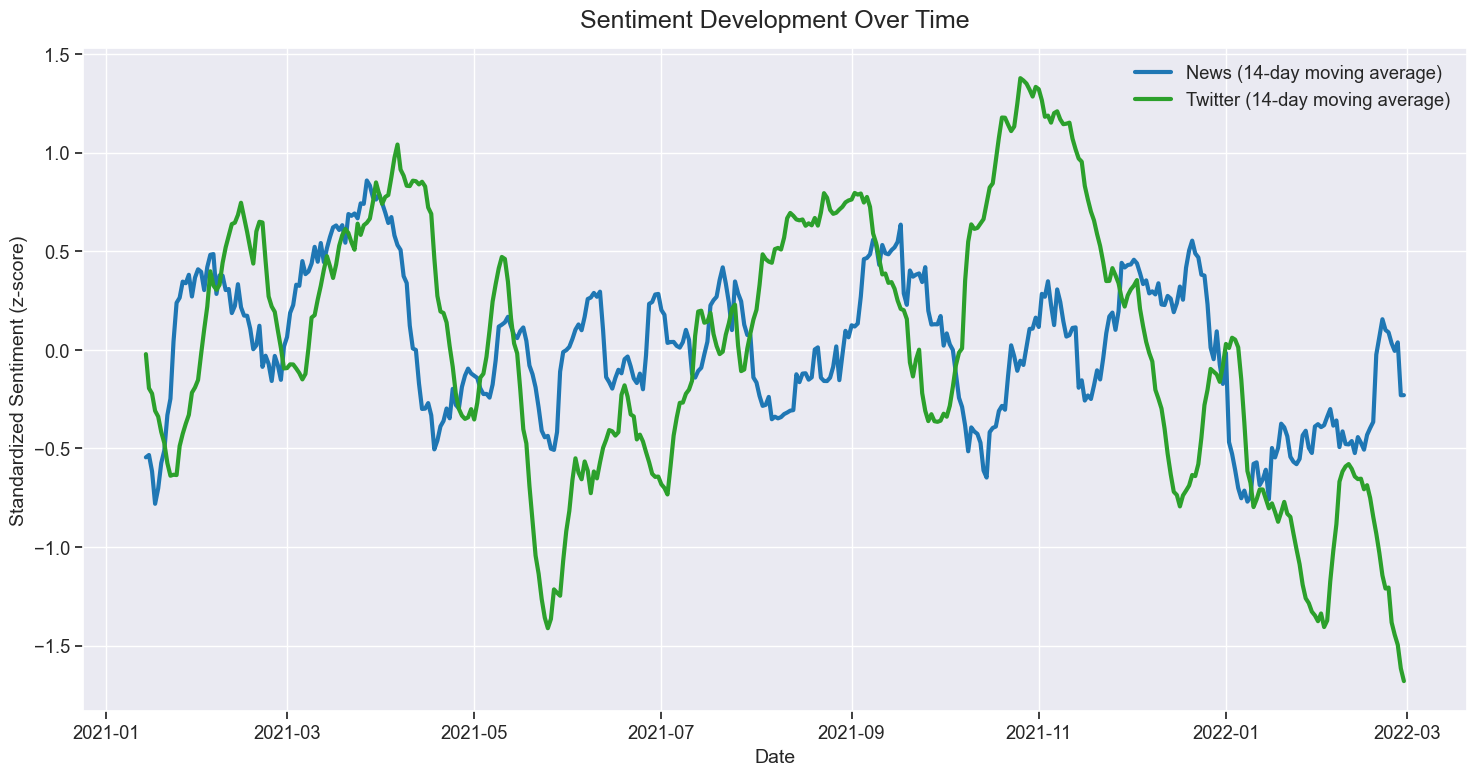

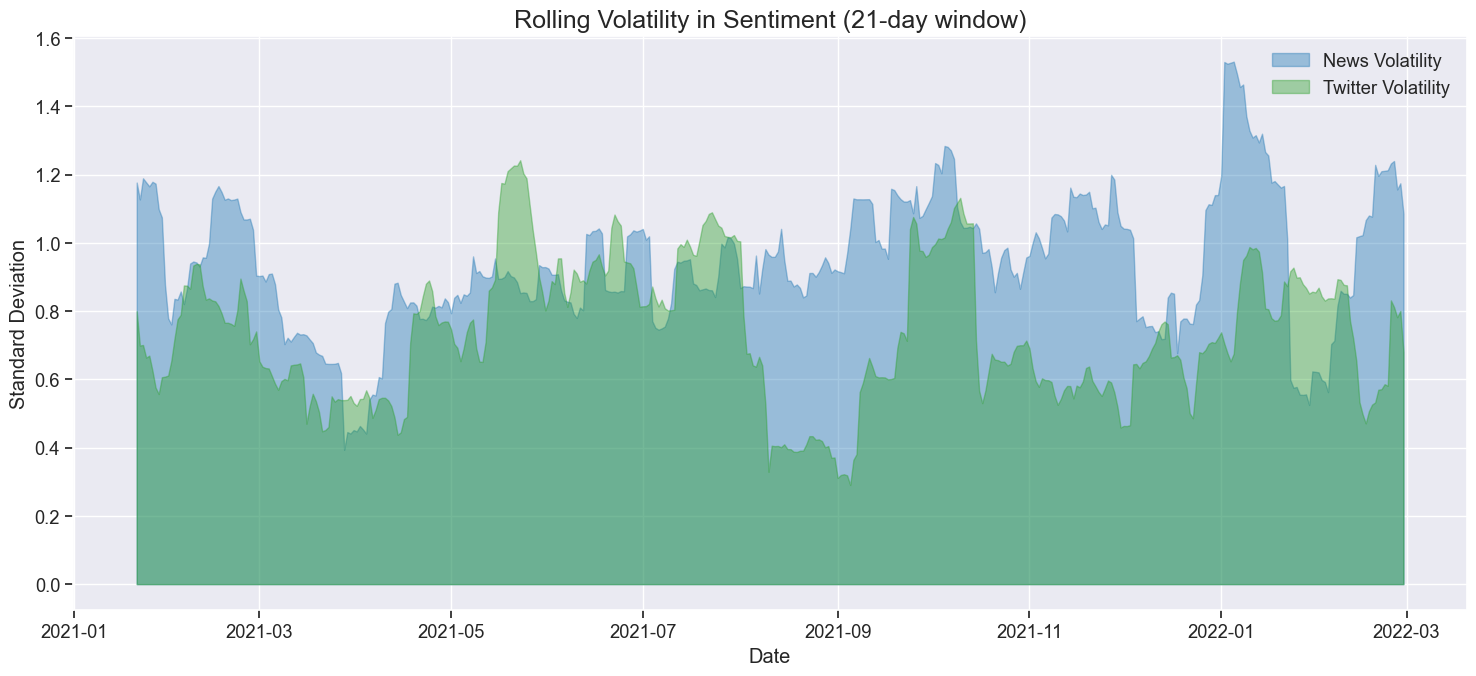

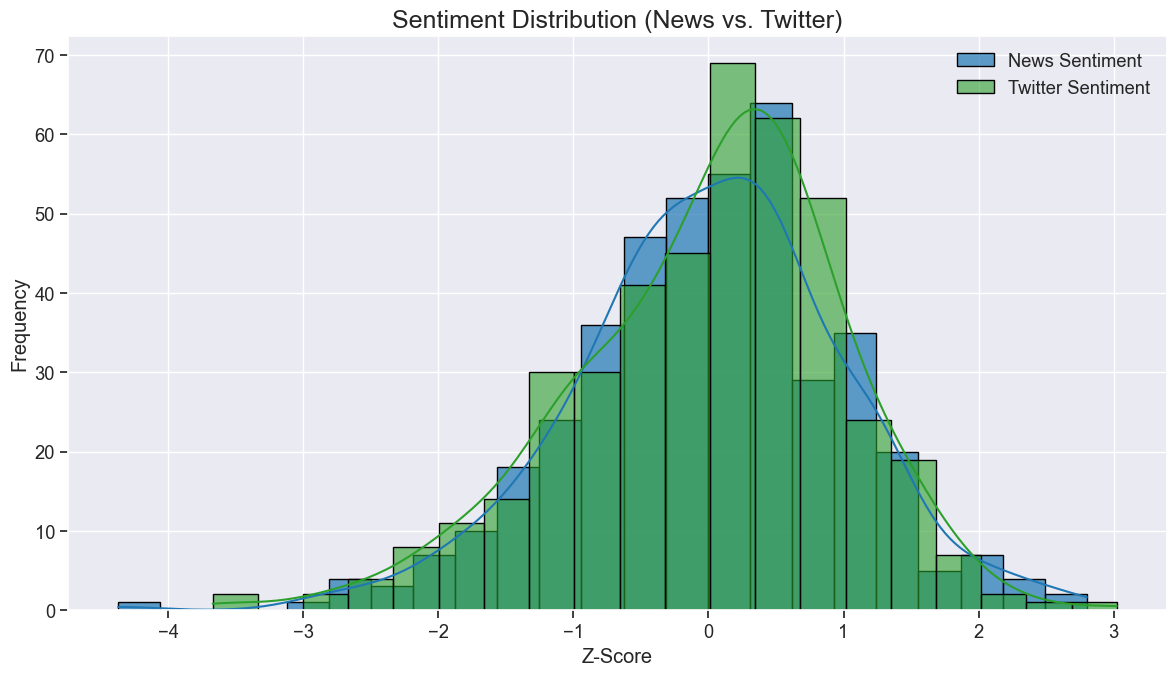

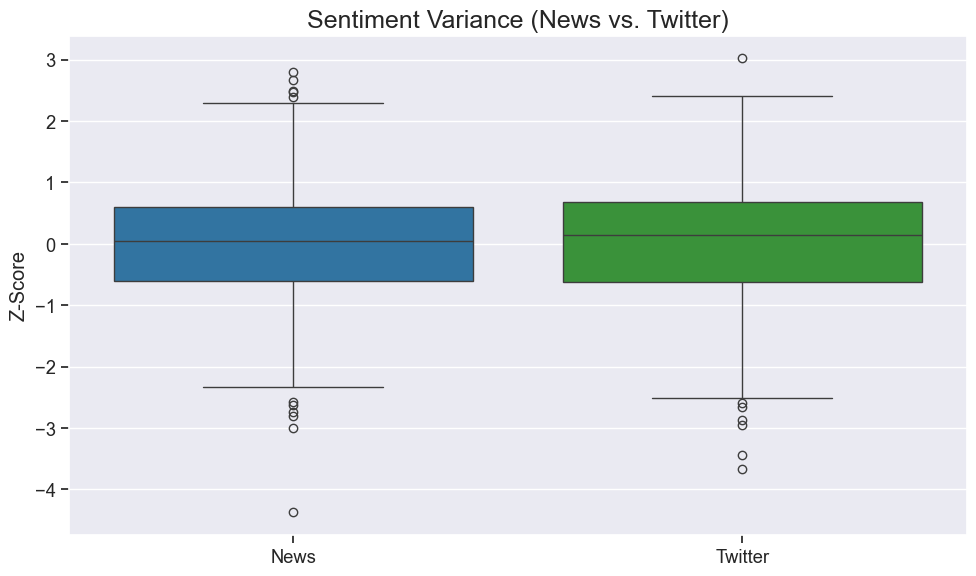

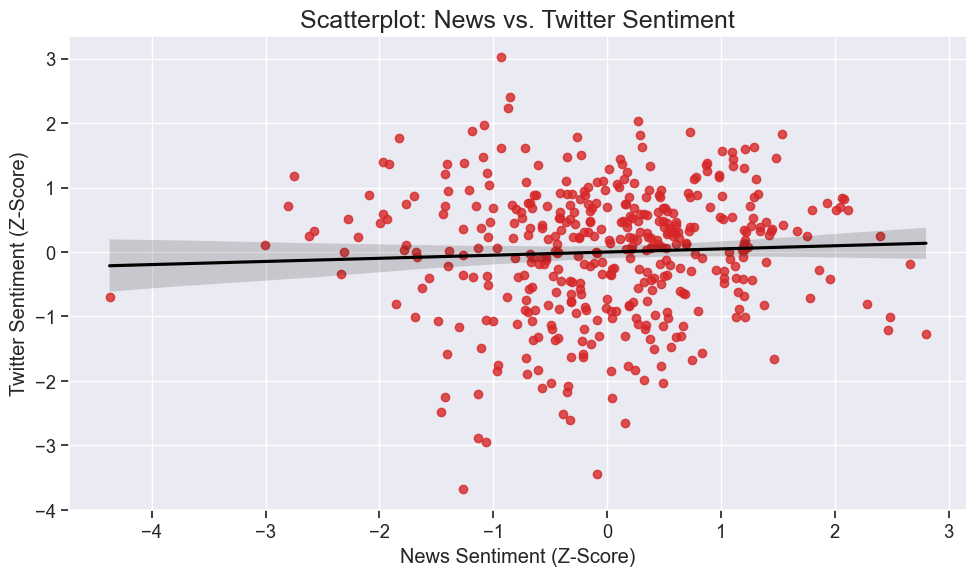

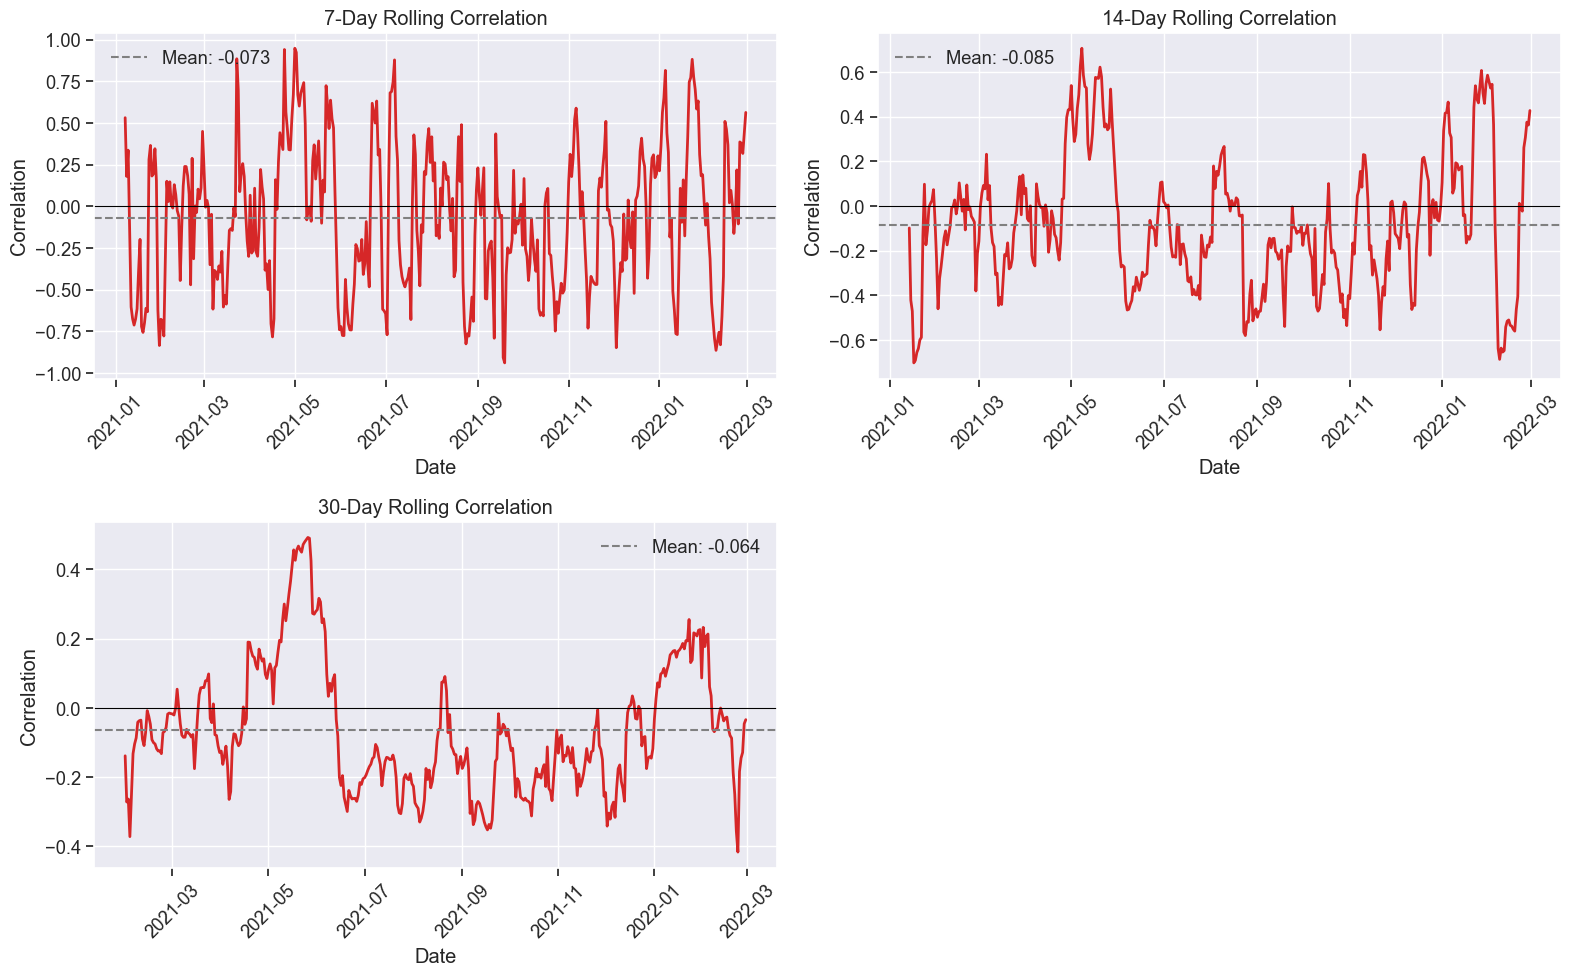


DETAILED ROLLING CORRELATION ANALYSIS

7-DAY ROLLING CORRELATION:
  Mean correlation: -0.0732
  Standard deviation: 0.4266
  Median correlation: -0.0568
  Range: [-0.9402, 0.9481]
  25%-75% quartiles: [-0.4198, 0.2296]
  
Correlation strength distribution:
    Strong positive correlation (>0.5): 40/418 (9.6%)
    Moderate positive correlation (0.3–0.5): 45/418 (10.8%)
    Moderate negative correlation (-0.5 to -0.3): 62/418 (14.8%)
    Strong negative correlation (<-0.5): 78/418 (18.7%)

14-DAY ROLLING CORRELATION:
  Mean correlation: -0.0855
  Standard deviation: 0.2933
  Median correlation: -0.1105
  Range: [-0.7026, 0.7058]
  25%-75% quartiles: [-0.2862, 0.0650]
  
Correlation strength distribution:
    Strong positive correlation (>0.5): 21/411 (5.1%)
    Moderate positive correlation (0.3–0.5): 30/411 (7.3%)
    Moderate negative correlation (-0.5 to -0.3): 72/411 (17.5%)
    Strong negative correlation (<-0.5): 27/411 (6.6%)

30-DAY ROLLING CORRELATION:
  Mean correlation: -0.06

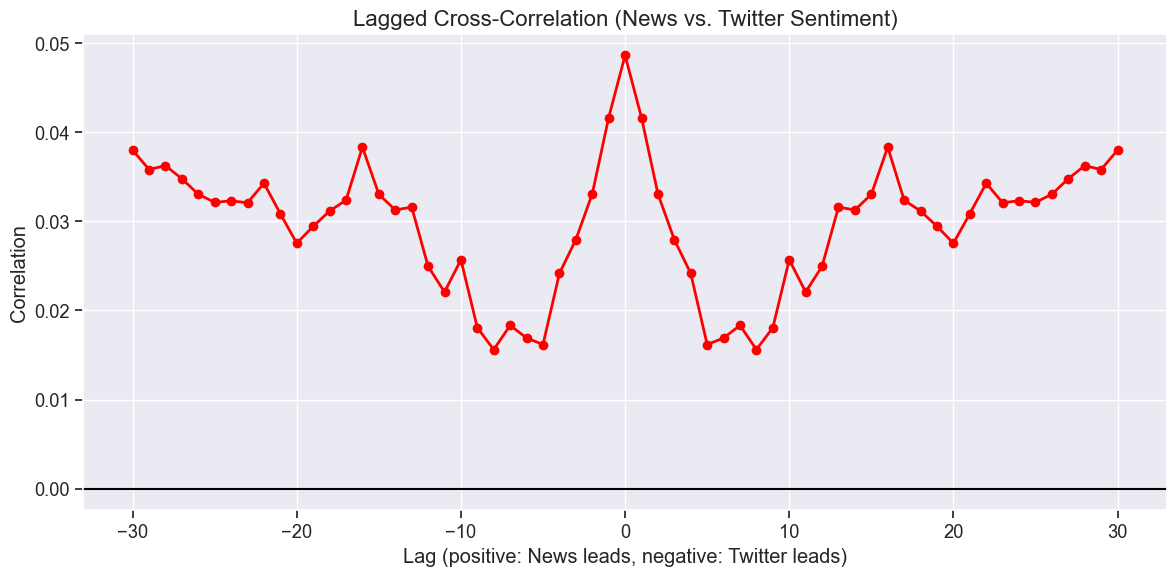


SUMMARY OF SENTIMENT ANALYSIS RESULTS

Descriptive Statistics:
       News Sentiment  Twitter Sentiment
count        424.0000           424.0000
mean          -0.0000            -0.0000
std            1.0000             1.0000
min           -4.3705            -3.6706
25%           -0.6051            -0.6189
50%            0.0396             0.1364
75%            0.5953             0.6783
max            2.8021             3.0234

Distribution Characteristics:
  News - Skewness: -0.3025, Kurtosis: 0.8699
  Twitter - Skewness: -0.5195, Kurtosis: 0.5466

Statistical Tests:
  T-test: t = -0.0000, p = 1.0000 → Not significant
  Levene’s Test: statistic = 0.0004, p = 0.9848 → Equal variances

Correlation Analysis:
  Overall Pearson correlation: 0.0486
  Maximum lagged correlation: 0.0486 at lag 0
  Interpretation: Sentiment is simultaneously correlated


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("colorblind")
sns.set_context("notebook", font_scale=1.2)

colors = {
    'news': '#1f77b4',
    'twitter': '#2ca02c',
    'highlight': '#d62728',
}

plt.rcParams['font.family'] = 'sans-serif'

# ===================== DATA LOADING =====================
news_path = r"C:\Users\Kasper Hassing\Desktop\Speciale_KryptoSentiment\data\news_data\bitcoin_news_14months_mean_zscore_final.csv"
tweets_path = r"C:\Users\Kasper Hassing\Desktop\Speciale_KryptoSentiment\data\twitter_posts\bitcoin_tweets_cleaned_21_vadercrypto_14month_final.csv"

try:
    news_df = pd.read_csv(news_path)
    tweets_df = pd.read_csv(tweets_path)

    news_df['date'] = pd.to_datetime(news_df['date'])
    tweets_df['datetime'] = pd.to_datetime(tweets_df['datetime'])
    combined_df = pd.merge(news_df, tweets_df, left_on='date', right_on='datetime', suffixes=('_news', '_tweets'))
    combined_df = combined_df.drop(columns=['datetime'])
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    exit()

# ===================== DATA VALIDATION =====================
required_cols = ['ProsusAI/finbert_z_score', 'crypto_sentiment_z_score']
combined_df = combined_df.dropna(subset=required_cols)
if len(combined_df) < 30:
    print(f"Insufficient data points: {len(combined_df)}")
    exit()

# ===================== STATISTICAL ANALYSIS =====================
# Descriptive statistics
stats_detailed = combined_df[['ProsusAI/finbert_z_score', 'crypto_sentiment_z_score']].describe()

# Skewness and kurtosis
news_skew = combined_df['ProsusAI/finbert_z_score'].skew()
twitter_skew = combined_df['crypto_sentiment_z_score'].skew()
news_kurt = combined_df['ProsusAI/finbert_z_score'].kurt()
twitter_kurt = combined_df['crypto_sentiment_z_score'].kurt()

# T-test
t_stat, p_value = stats.ttest_ind(
    combined_df['ProsusAI/finbert_z_score'], 
    combined_df['crypto_sentiment_z_score']
)

# Levene’s test
levene_stat, levene_p = stats.levene(
    combined_df['ProsusAI/finbert_z_score'], 
    combined_df['crypto_sentiment_z_score']
)

# ===================== VISUALIZATIONS =====================
# Rolling average (14-day moving average)
window_size = min(14, len(combined_df) // 4)
combined_df['news_smooth'] = combined_df['ProsusAI/finbert_z_score'].rolling(window=window_size).mean()
combined_df['twitter_smooth'] = combined_df['crypto_sentiment_z_score'].rolling(window=window_size).mean()

# 1. SENTIMENT OVER TIME (with smoothing)
window_size = min(14, len(combined_df) // 4)
combined_df['news_smooth'] = combined_df['ProsusAI/finbert_z_score'].rolling(window=window_size).mean()
combined_df['tweets_smooth'] = combined_df['crypto_sentiment_z_score'].rolling(window=window_size).mean()

plt.figure(figsize=(15, 8))
plt.plot(combined_df['date'], combined_df['news_smooth'], 
         label=f'News ({window_size}-day moving average)', color=colors['news'], linewidth=3)
plt.plot(combined_df['date'], combined_df['tweets_smooth'], 
         label=f'Twitter ({window_size}-day moving average)', color=colors['twitter'], linewidth=3)
plt.title('Sentiment Development Over Time', fontsize=18, pad=15)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Standardized Sentiment (z-score)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

# Rolling volatility (21-day std)
vol_window = min(21, len(combined_df) // 3)
combined_df['news_vol'] = combined_df['ProsusAI/finbert_z_score'].rolling(window=vol_window).std()
combined_df['twitter_vol'] = combined_df['crypto_sentiment_z_score'].rolling(window=vol_window).std()

plt.figure(figsize=(15, 7))
plt.fill_between(combined_df['date'], combined_df['news_vol'], color=colors['news'], alpha=0.4, label='News Volatility')
plt.fill_between(combined_df['date'], combined_df['twitter_vol'], color=colors['twitter'], alpha=0.4, label='Twitter Volatility')
plt.title(f'Rolling Volatility in Sentiment ({vol_window}-day window)', fontsize=18)
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.legend()
plt.tight_layout()
plt.show()

# Histogram
plt.figure(figsize=(12, 7))
sns.histplot(combined_df['ProsusAI/finbert_z_score'], kde=True, color=colors['news'], label='News Sentiment', alpha=0.7)
sns.histplot(combined_df['crypto_sentiment_z_score'], kde=True, color=colors['twitter'], label='Twitter Sentiment', alpha=0.6)
plt.title('Sentiment Distribution (News vs. Twitter)', fontsize=18)
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=[
    combined_df['ProsusAI/finbert_z_score'], 
    combined_df['crypto_sentiment_z_score']], 
    palette=[colors['news'], colors['twitter']])
plt.xticks([0, 1], ['News', 'Twitter'])
plt.title('Sentiment Variance (News vs. Twitter)', fontsize=18)
plt.ylabel('Z-Score')
plt.tight_layout()
plt.show()

# Scatterplot with regression
plt.figure(figsize=(10, 6))
sns.regplot(x='ProsusAI/finbert_z_score', y='crypto_sentiment_z_score', data=combined_df,
            color=colors['highlight'], line_kws={"color": "black"})
plt.title("Scatterplot: News vs. Twitter Sentiment", fontsize=18)
plt.xlabel("News Sentiment (Z-Score)")
plt.ylabel("Twitter Sentiment (Z-Score)")
plt.tight_layout()
plt.show()

# Rolling correlation
windows = [7, 14, 30]
rolling_correlations = {}

plt.figure(figsize=(16, 10))
for i, window in enumerate(windows):
    if window >= len(combined_df):
        continue
    rolling_corr = combined_df['ProsusAI/finbert_z_score'].rolling(window).corr(combined_df['crypto_sentiment_z_score'])
    rolling_correlations[window] = rolling_corr
    plt.subplot(2, 2, i+1)
    plt.plot(combined_df['date'], rolling_corr, color=colors['highlight'], linewidth=2)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.axhline(rolling_corr.mean(), color='gray', linestyle='--', label=f'Mean: {rolling_corr.mean():.3f}')
    plt.title(f'{window}-Day Rolling Correlation')
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.legend()
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
# ===================== ROLLING CORRELATION STATISTICS =====================
print("\n" + "="*60)
print("DETAILED ROLLING CORRELATION ANALYSIS")
print("="*60)

for window, rolling_corr in rolling_correlations.items():
    rolling_corr_clean = rolling_corr.dropna()
    if rolling_corr_clean.empty:
        continue

    stats_dict = {
        'mean': rolling_corr_clean.mean(),
        'std': rolling_corr_clean.std(),
        'min': rolling_corr_clean.min(),
        'max': rolling_corr_clean.max(),
        'median': rolling_corr_clean.median(),
        'q25': rolling_corr_clean.quantile(0.25),
        'q75': rolling_corr_clean.quantile(0.75),
        'total': len(rolling_corr_clean),
        'strong_pos': (rolling_corr_clean > 0.5).sum(),
        'moderate_pos': ((rolling_corr_clean > 0.3) & (rolling_corr_clean <= 0.5)).sum(),
        'moderate_neg': ((rolling_corr_clean < -0.3) & (rolling_corr_clean >= -0.5)).sum(),
        'strong_neg': (rolling_corr_clean < -0.5).sum(),
    }

    print(f"\n{window}-DAY ROLLING CORRELATION:")
    print(f"  Mean correlation: {stats_dict['mean']:.4f}")
    print(f"  Standard deviation: {stats_dict['std']:.4f}")
    print(f"  Median correlation: {stats_dict['median']:.4f}")
    print(f"  Range: [{stats_dict['min']:.4f}, {stats_dict['max']:.4f}]")
    print(f"  25%-75% quartiles: [{stats_dict['q25']:.4f}, {stats_dict['q75']:.4f}]")
    print(f"  \nCorrelation strength distribution:")
    print(f"    Strong positive correlation (>0.5): {stats_dict['strong_pos']}/{stats_dict['total']} ({stats_dict['strong_pos']/stats_dict['total']*100:.1f}%)")
    print(f"    Moderate positive correlation (0.3–0.5): {stats_dict['moderate_pos']}/{stats_dict['total']} ({stats_dict['moderate_pos']/stats_dict['total']*100:.1f}%)")
    print(f"    Moderate negative correlation (-0.5 to -0.3): {stats_dict['moderate_neg']}/{stats_dict['total']} ({stats_dict['moderate_neg']/stats_dict['total']*100:.1f}%)")
    print(f"    Strong negative correlation (<-0.5): {stats_dict['strong_neg']}/{stats_dict['total']} ({stats_dict['strong_neg']/stats_dict['total']*100:.1f}%)")


# Lagged cross-correlation
max_lag = min(30, len(combined_df) // 4)
cross_corr = []
lags = range(-max_lag, max_lag+1)

for lag in lags:
    if lag == 0:
        corr = combined_df['ProsusAI/finbert_z_score'].corr(combined_df['crypto_sentiment_z_score'])
    elif lag > 0:
        corr = combined_df['ProsusAI/finbert_z_score'].iloc[:-lag].corr(
               combined_df['crypto_sentiment_z_score'].iloc[lag:])
    else:
        corr = combined_df['ProsusAI/finbert_z_score'].iloc[-lag:].corr(
               combined_df['crypto_sentiment_z_score'].iloc[:lag])
    cross_corr.append(corr)

plt.figure(figsize=(12, 6))
plt.plot(lags, cross_corr, color='red', marker='o', linewidth=2)
plt.title('Lagged Cross-Correlation (News vs. Twitter Sentiment)', fontsize=16)
plt.xlabel('Lag (positive: News leads, negative: Twitter leads)')
plt.ylabel('Correlation')
plt.axhline(0, color='black')
plt.grid(True)
plt.tight_layout()
plt.show()

# ===================== RESULT SUMMARY =====================
print("\n" + "="*60)
print("SUMMARY OF SENTIMENT ANALYSIS RESULTS")
print("="*60)

print("\nDescriptive Statistics:")
stats_detailed_renamed = stats_detailed.rename(columns={
    'ProsusAI/finbert_z_score': 'News Sentiment',
    'crypto_sentiment_z_score': 'Twitter Sentiment'
})
print(stats_detailed_renamed.round(4))

print("\nDistribution Characteristics:")
print(f"  News - Skewness: {news_skew:.4f}, Kurtosis: {news_kurt:.4f}")
print(f"  Twitter - Skewness: {twitter_skew:.4f}, Kurtosis: {twitter_kurt:.4f}")

print("\nStatistical Tests:")
print(f"  T-test: t = {t_stat:.4f}, p = {p_value:.4f} → {'Significant' if p_value < 0.05 else 'Not significant'}")
print(f"  Levene’s Test: statistic = {levene_stat:.4f}, p = {levene_p:.4f} → {'Equal variances' if levene_p > 0.05 else 'Different variances'}")

overall_corr = combined_df['ProsusAI/finbert_z_score'].corr(combined_df['crypto_sentiment_z_score'])
max_corr_idx = np.argmax(np.abs(cross_corr))
max_corr_lag = lags[max_corr_idx]
max_corr_value = cross_corr[max_corr_idx]

print("\nCorrelation Analysis:")
print(f"  Overall Pearson correlation: {overall_corr:.4f}")
print(f"  Maximum lagged correlation: {max_corr_value:.4f} at lag {max_corr_lag}")

if max_corr_lag > 0:
    print(f"  Interpretation: News sentiment leads Twitter by {max_corr_lag} days")
elif max_corr_lag < 0:
    print(f"  Interpretation: Twitter sentiment leads News by {abs(max_corr_lag)} days")
else:
    print("  Interpretation: Sentiment is simultaneously correlated")
